In [1]:
%matplotlib notebook
import os
import numpy as np
from glob import glob
import torch
from torch import nn
from torch.nn import functional as F
import torch.utils.data as td
import torchvision as tv
import nntools as nt
from PIL import Image
from matplotlib import pyplot as plt
import torch.optim as optim
import torchvision.transforms as transforms

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


### Load image

In [3]:
class styleLoader():
    def __init__(self, root_dir, image_size=(512, 512)):
        self.image_size = image_size
        self.images_dir = root_dir
    def __getitem__(self, idx):
        img = Image.open(self.images_dir)
        transform = tv.transforms.Compose([
            # COMPLETE
            tv.transforms.Resize(self.image_size),
            tv.transforms.ToTensor(),
            ])
        x = transform(img)
        x = x.unsqueeze(0)
        return x.to(device, torch.float)

In [4]:
def myimshow(image, ax=plt):
    image = image.to('cpu').clone().numpy()
    image = image.squeeze(0)
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    #image = (image + 1) / 2
    #image[image < 0] = 0
    #image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

<IPython.core.display.Javascript object>


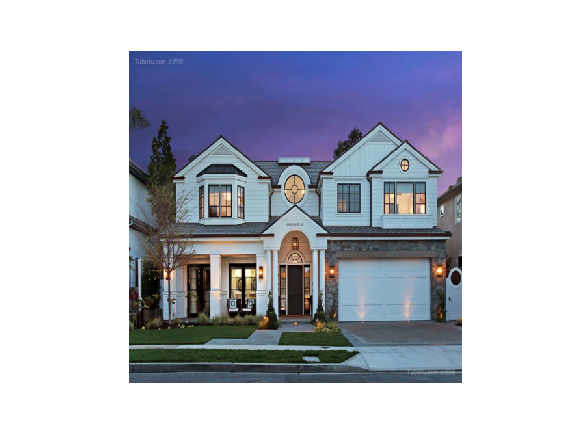

<IPython.core.display.Javascript object>


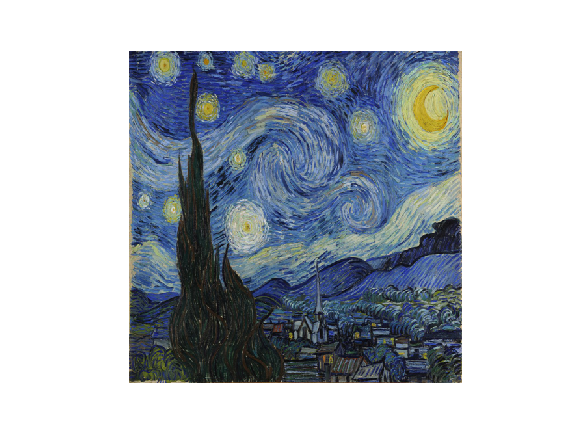

In [5]:
contentImg = styleLoader("fangzi.jpg")[0]
styleImg = styleLoader("fangao.jpg")[0]
plt.figure()
myimshow(contentImg, ax=plt)
plt.figure()
myimshow(styleImg, ax=plt)

### Loss function

In [6]:
class contentLoss(nn.Module):
    def __init__(self, target):
        super(contentLoss, self).__init__()
        self.target = target.detach()
    def forward(self, input):
        N = input.shape[-1]
        self.loss = F.mse_loss(input, self.target)*N
        return input  

In [7]:
def gram(input):
    batch_size, channel, height, width = input.shape
    x = input.view(batch_size*channel, height*width)
    return torch.mm(x, x.t())

In [8]:
class styleLoss(nn.Module):
    def __init__(self, target):
        super(styleLoss, self).__init__()
        self.target = target
        
    def forward(self, input):
        target_gram = gram(self.target)
        input_gram = gram(input)
        self.loss = F.mse_loss(input_gram, target_gram)
        return input
    

### Load model

In [9]:
vgg = tv.models.vgg19(pretrained=True).features.to(device).eval()

In [10]:
def constructModel(model, contentImg, styleImg, contentLayers, styleLayers):
    contentLoss_list = []
    styleLoss_list = []

    newModel = nn.Sequential()

    convCount = 0
    poolCount = 0
    reluCount = 0
    for layer in model.children():
        if isinstance(layer, nn.Conv2d):
            convCount += 1
            name = 'conv_'+str(convCount)
            newModel.add_module(name, layer)
            if name in contentLayers:
                content = newModel(contentImg)
                content_loss = contentLoss(content)
                newModel.add_module("content_loss_"+str(convCount), content_loss)
                contentLoss_list.append(content_loss)

            if name in styleLayers:
                style = newModel(styleImg).detach()
                style_loss = styleLoss(style)
                newModel.add_module("style_loss_"+str(convCount), style_loss)
                styleLoss_list.append(style_loss)
        if isinstance(layer, nn.ReLU):
            reluCount += 1
            name = 'relu_'+str(reluCount)
            layer = nn.ReLU(inplace=False)
            newModel.add_module(name, layer)
        if isinstance(layer, nn.MaxPool2d):
            poolCount += 1
            name = 'pool_'+str(poolCount)
            newModel.add_module(name, nn.AvgPool2d((2,2)))

    return newModel, styleLoss_list, contentLoss_list

### start training

In [11]:
def trainHelper(contentImg, styleImg, epoch, model, contentLayers, styleLayers, beta):
    trainImg = contentImg
    input_param = trainImg.requires_grad_()
    optimizer = optim.LBFGS([input_param])
    newModel,styleLoss_list,contentLoss_list = constructModel(model, contentImg, styleImg, contentLayers, styleLayers )
    i = [0]
    while i[0] <= epoch:
        def closure():
            trainImg.data.clamp(0,1)
            optimizer.zero_grad()
            newModel(trainImg)
            content_loss = 0
            style_loss = 0
            for loss_val in contentLoss_list:
                content_loss += loss_val.loss
            for loss_val in styleLoss_list:
                style_loss += loss_val.loss
            totalLoss = content_loss * 1 + style_loss * beta
            totalLoss.backward()
            i[0] += 1
            #if i[0] % 50 == 0:
                #print("epoch:" + str(i[0]))
                #print("Style Loss :" + str(style_loss))
                #print("Content Loss :" + str(content_loss))
            return totalLoss
        optimizer.step(closure)
    trainImg.data.clamp_(0,1)
    return trainImg

In [12]:
def core(newModel, trainImg, optimizer, contentLoss_list, styleLoss_list, i):
    trainImg.data.clamp(0,1)
    optimizer.zero_grad()
    newModel(trainImg)
    content_loss = 0
    style_loss = 0
    for loss_val in contentLoss_list:
        content_loss += loss_val.loss
    for loss_val in styleLoss_list:
        style_loss += loss_val.loss
    totalLoss = content_loss * 1 + style_loss * 100000
    totalLoss.backward()
    i[0] += 1
    #if i[0] % 50 == 0:
        #print("epoch:" + str(i[0]))
        #print("Style Loss :" + str(style_loss))
        #print("Content Loss :" + str(content_loss))
    return totalLoss

<IPython.core.display.Javascript object>


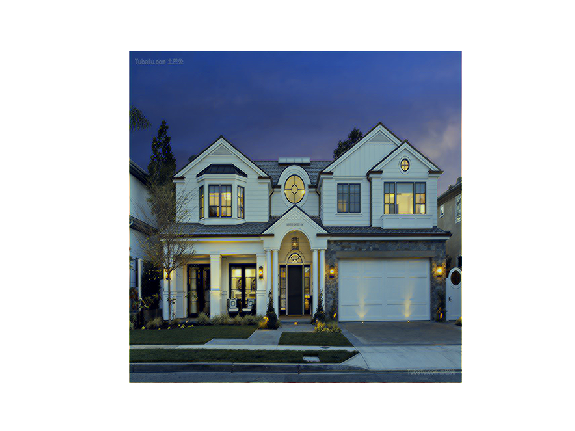

<IPython.core.display.Javascript object>


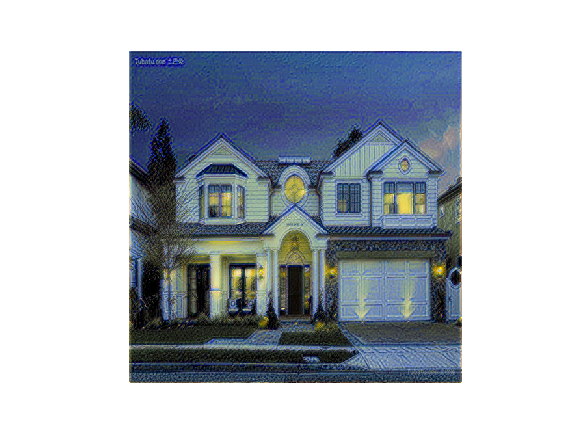

<IPython.core.display.Javascript object>


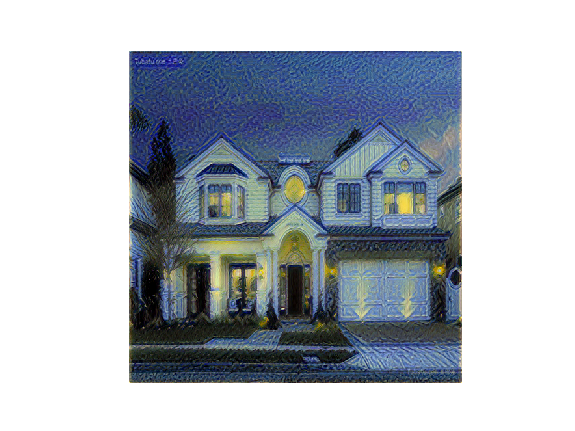

<IPython.core.display.Javascript object>


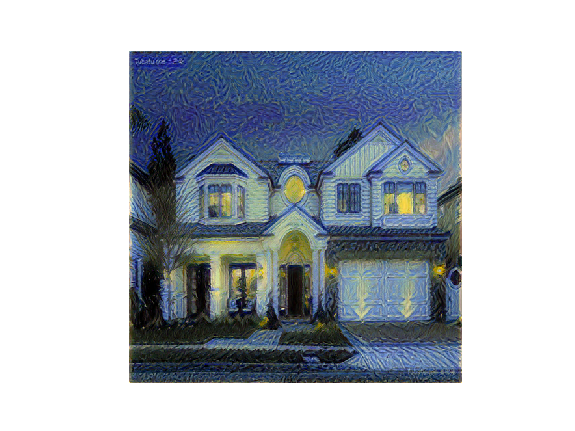

<IPython.core.display.Javascript object>


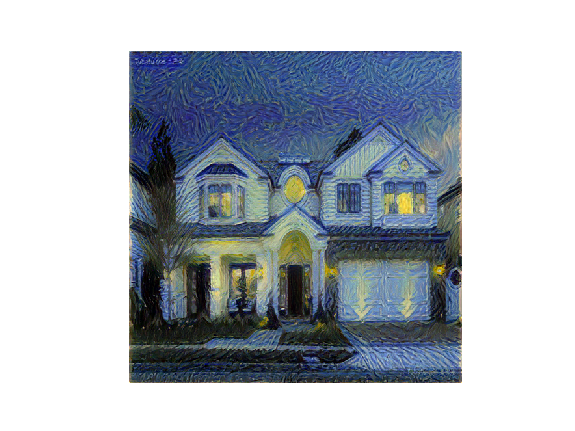

In [13]:
contentLayers = ['conv_4']
styleLayers = [['conv_1'],['conv_1', 'conv_2'],['conv_1', 'conv_2', 'conv_3'],['conv_1', 'conv_2', 'conv_3', 'conv_4'],['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']]
for i in range(len(styleLayers)):
    outputImg = trainHelper(contentImg, styleImg, 300, vgg, contentLayers, styleLayers[i], 10000)
    plt.figure()
    myimshow(outputImg.detach(), ax=plt)